# IP21 and Alarm data analyse

Author: Mark Chinnock, Anova Data Solutions   
Date: July 2021   
## Content

Introduction

    1.1 Background

    1.2 Problem

    1.3 Audience

    Data
    Methodology
    Results
    Discussion
    Conclusion



## Introduction

IP21 data is a generic name given to data recorded from machine sensors on each of the manufacturing lines.  The sensors provide readings of (but not exclusively): temperature, humidity, pressure, and counters.   
<p>The readings come from the machines at regular timed intervals (time series data) regardless of the current reading/performance from the sensor – ie it is not alerting of a specific scenario/reading.  Each sensor is documented on a detailed schematic and named so that it can be mapped to a plant/line/machine/sensor type.
<p>There are also alerts/alarms that are issued from the manufacturing lines.  The alarms have also been named to indicate specific areas / machines.  Although often mentioned along with IP21, there is no direct correlation between the alerts/alarms being issued into one database and the IP21 data being issued into another database. There would need to be a complex mapping exercise to link specific alerts/alarms to related IP21 data.


Import some libraries

In [88]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1


dir_IP21 = ConfigSectionMap("SectionOne")['ip21']
dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
mydocs = ConfigSectionMap("SectionOne")['mydocs']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_alarms is %s" % (dir_alarms))



dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_alarms is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/Alarms_data/


In [85]:
import pandas as pd
import numpy as np
import datetime

# this dir should point at where ever your sanofi Mclaren directory is syncing
# dir = "C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Race Dashboard data/"

# from sys import platform
# # if platform == "linux" or platform == "linux2":
#     # linux    
# if platform == "darwin":
#     # OS X
#     dir = "/Users/mark/Documents/GitHub/IP21/"
# elif platform == "win32":
#     # Windows...
#     # dir = "C:/Users/mark_/Documents/McLaren2021/Sanofi/IP21/"
#     # trying the microsoft teams sanofi share folder
#     dir = "C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/OEE data/"

    


In [86]:
def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


In [89]:
# read OEE Detailed Events report file for AL6 packaging machines
file = (dir_sanofi_share + 'OEE data/AL6_Packaging_Detailed_Events.xlsx')
df = pd.read_excel(file, parse_dates=True, index_col='Start Date')

# read in OEE Detailed losses Analysis for AL6
file = (dir_sanofi_share + 'OEE data/AL6_OEE_Losses.xlsx')
df_OEE = pd.read_excel(file)
df_OEE.rename(columns=({'Calendar Day':'Date', 
                        'Point of OEE':'OEE',
                        'Loss Category':'Category'}), inplace=True)
df_OEE['OEE'] = pd.to_numeric(df_OEE['OEE'], errors='coerce')
df_OEE['OEE'] = df_OEE['OEE'].mul(100)
df_OEE = df_OEE.set_index('Date')
df_OEE.shape

(2741, 2)

get rid of any pre April 2021 data - wasn't valid for AL6

In [90]:
start_date = '2021-04-01'
end_date = datetime.date.today()
df_OEE = df_OEE[df_OEE.index >= start_date].sort_values('Date')
df_OEE.Category.unique()

array(['Qualifizierung/Validierung (11)', 'Production', 'Minor Loss',
       'Without cause', 'Sonstiges und Unbekannte (26)',
       'Störungen und Fehlerbehebung (25)', 'Speed Loss',
       'W&I (geplante Linie) (23)',
       'Organisatorische Verluste und Wartezeiten (22)',
       'Rüstvorgänge (21)', 'Ungeplante Linie (14)',
       'Feier/Brückentag (12)', 'Autonome Wartungen (24)',
       'vorbeugende Instandhaltung/Wartung (13)', 'Sonstige (15)',
       'Quality Loss'], dtype=object)

In [91]:
df.head()

,Shift Long Name,End Date,Duration (min.),Stoppage Reason 3,Last Level Reason,Machine,Comments,Creator
Start Date,,,,,,,,
2021-04-01 06:05:43,FRUE - 01/04/2021 06:00:00,2021-04-01 06:06:33,0.833333,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:22:19,FRUE - 01/04/2021 06:00:00,2021-04-01 06:23:43,1.400000,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:54:09,FRUE - 01/04/2021 06:00:00,2021-04-01 06:55:52,1.716667,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:56:00,FRUE - 01/04/2021 06:00:00,2021-04-01 06:57:59,1.983333,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH
2021-04-01 06:58:05,FRUE - 01/04/2021 06:00:00,2021-04-01 06:59:42,1.616667,Minor Loss,-,AL6 Kartonierer,---,MIIPCOPQH


Let's translate these stoppage categories!

| German | English | 
| ------ | ------- |
|Qualifizierung/Validierung (11)|Qualification/validation|    
|Sonstiges und Unbekannte (26)|Other and unknown|   
|Störungen und Fehlerbehebung (25)|Malfunctions and troubleshooting|    
|W&I (geplante Linie) (23)|W&I (planned line)|   
|Organisatorische Verluste und Wartezeiten (22)|Organizational losses and waiting times|   
|Rüstvorgänge (21)|Changeover|    
|Ungeplante Linie (14)|Unplanned Line|   
|Feier/Brückentag (12)|Celebration / long day|   
|Autonome Wartungen (24)|Autonomous maintenance|   
|vorbeugende Instandhaltung/Wartung (13)|Preventive maintenance / servicing|   
|Sonstige (15)|Other|   



In [92]:
df_OEE['Category'].replace({
'Qualifizierung/Validierung (11)':'Qualification/validation', 
'Sonstiges und Unbekannte (26)':'Other and unknown',
'Störungen und Fehlerbehebung (25)':'Malfunctions and troubleshooting', 
'W&I (geplante Linie) (23)':'W&I (planned line)',
'Organisatorische Verluste und Wartezeiten (22)':'Organizational losses and waiting times',
'Rüstvorgänge (21)':'Changeover', 
'Ungeplante Linie (14)':'Unplanned Line',
'Feier/Brückentag (12)':'Celebration / long day', 
'Autonome Wartungen (24)':'Autonomous maintenance',
'vorbeugende Instandhaltung/Wartung (13)':'Preventive maintenance / servicing', 
'Sonstige (15)':'Other'}, inplace=True)

df['Stoppage Reason 3'].replace({
'Qualifizierung/Validierung (11)':'Qualification/validation', 
'Sonstiges und Unbekannte (26)':'Other and unknown',
'Störungen und Fehlerbehebung (25)':'Malfunctions and troubleshooting', 
'W&I (geplante Linie) (23)':'W&I (planned line)',
'Organisatorische Verluste und Wartezeiten (22)':'Organizational losses and waiting times',
'Rüstvorgänge (21)':'Changeover', 
'Ungeplante Linie (14)':'Unplanned Line',
'Feier/Brückentag (12)':'Celebration / long day', 
'Autonome Wartungen (24)':'Autonomous maintenance',
'vorbeugende Instandhaltung/Wartung (13)':'Preventive maintenance / servicing', 
'Sonstige (15)':'Other'}, inplace=True)

In [93]:
# do I need this?  

# set up date range with min start_date and max start_date recorded earlier
daterange = pd.date_range(start = start_date, end = end_date, freq='D')

pd.DataFrame({'Date': daterange.date})

# df = pd.merge(df1, df, on=['Date','UI'], how='outer')

,Date
0,2021-04-01
1,2021-04-02
2,2021-04-03
3,2021-04-04
4,2021-04-05
...,...
120,2021-07-30
121,2021-07-31
122,2021-08-01
123,2021-08-02


In [94]:
df_OEE['Month'] = df_OEE.index.strftime("%B")
df_OEE['Day'] = df_OEE.index.strftime("%d")
df_OEE.head()

# df_OEE.groupby(['Day', 'Month', 'Category'])[['OEE']].sum()

df_OEE['Month'] = df_OEE['Month'].astype(pd.api.types.CategoricalDtype(categories=['April','May','June', 'July'], ordered=True))


production = df_OEE[df_OEE.Category == ('Production')]
changeover = df_OEE[df_OEE.Category == ('Changeover')]

pivot = production.pivot(index='Day', columns='Month', values='OEE').style.background_gradient(cmap='Oranges_r')\
       # .format("{:.2f}")


pivot

Month,April,May,June,July
Day,,,,
01,43.382099,43.102778,54.364583,44.023148
02,16.429006,38.669444,21.286574,31.937310
03,61.401389,29.590123,44.448400,17.029861
04,0.008333,30.714903,80.177778,0.000000
05,nan,32.486574,53.335463,nan
06,27.228704,33.511179,18.668519,nan
07,33.662500,67.476157,29.443308,nan
08,50.584259,60.335648,39.222029,nan
09,49.161111,41.127778,25.174102,51.367983


In [95]:
pivot.to_excel(dir_sanofi_share + "OEE data/AL6_production_losses_pivot.xlsx")

In [96]:
category_order = ['Production',
'Organizational losses and waiting times', 
'Changeover', 
'Malfunctions and troubleshooting',
'Other and unknown', 
'Without cause', 
'Minor Loss', 
'Speed Loss', 
'Autonomous maintenance',
'Celebration / long day', 
'Other',
'Preventive maintenance / servicing', 
'Quality Loss',
'Unplanned Line',
'W&I (planned line)',
'Qualification/validation']

not using this one at the moment, as the categories are all over the place

In [97]:
writer = pd.ExcelWriter(dir_sanofi_share + 'OEE data/AL6_OEE_Losses_pivot.xlsx', engine='xlsxwriter')
for i in df_OEE.Month.unique():
    pivot_OEE = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE').filter(regex=i)
    styler_OEE = pivot_OEE.style.background_gradient(cmap='Oranges')\
        .background_gradient(subset=['Production'], cmap='Greens')\
        # .format("{:,.2f}") # neither of these output to excel
        # .set_precision(2)  # neither of these output to excel
    
    styler_OEE.to_excel(writer, sheet_name=i)
    # pivot_OEE.to_excel(writer, sheet_name=i)
    workbook = writer.book
    worksheet = writer.sheets[i]
    # workbook = writer.book
    # cell_format = workbook.add.format()
    decimal = workbook.add_format({'num_format': '0.00'})
    worksheet.set_column('A:Q', 20, decimal)
#     call function get_col_widths to auto size the excel columns
    # for x, width in enumerate(get_col_widths(pivot_OEE)):
    #     #set each column width to be 1*25 that of the max string so that it fits nicely
    #     worksheet.set_column(x, x, width * 1.25)    



# workbook = writer.book
# writer.save() # don't save until we've added more sheets below

This sorts the pivot by category, then month.

In [263]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Losses_pivot.xlsx', engine='xlsxwriter')

# pivot_OEE_sorted = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE')
# pivot_OEE_sorted.columns = pivot_OEE_sorted.columns.set_levels(
#     pd.CategoricalIndex(
#         pivot_OEE_sorted.columns.levels[0],
#         ['Production',
#         'Organizational losses and waiting times', 
#         'Changeover', 
#         'Malfunctions and troubleshooting',
#         'Other and unknown', 
#         'Without cause', 
#         'Minor Loss', 
#         'Speed Loss', 
#         'Autonomous maintenance',
#         'W&I (planned line)',
#         'Celebration / long day', 
#         'Other',
#         'Preventive maintenance / servicing', 
#         'Quality Loss',
#         'Unplanned Line',
#         'Qualification/validation'],
#         ordered=True
#     ), level=0
# )

# pivot_OEE_sorted = pivot_OEE_sorted.sort_index(axis=1).style.background_gradient(cmap='Oranges')\
#     .background_gradient(subset=['Production'], cmap='Purples')

# pivot_OEE_sorted.to_excel(writer)
# workbook = writer.book
# writer.save()

In [98]:
df_OEE.to_excel(dir_sanofi_share + 'OEE data/df_OEE_temp.xlsx')

In [99]:
pivot_OEE = df_OEE.pivot(index='Day', columns=['Category','Month'], values='OEE')
pivot_OEE.stack()

Category   Autonomous maintenance  Celebration / long day  Changeover  \
Day Month                                                               
01  April                0.000000                     0.0   11.976852   
    May                  0.312500                     NaN    4.842593   
    June                 0.619213                     NaN    0.000000   
    July                 7.040509                     NaN    0.000000   
02  April                0.000000                     0.0   18.625000   
...                           ...                     ...         ...   
29  June                 1.216992                     NaN   11.150019   
30  April                0.000000                     NaN    7.019676   
    May                  0.000000                     NaN   29.032407   
    June                10.797222                     NaN    7.166667   
31  May                  1.012346                     NaN    0.000000   

Category   Malfunctions and troubleshooting  Minor Loss  \
Day Month                                                 
01  April                         22.481481   12.870370   
    May                           21.302083   23.060185   
    June                           2.065972   10.186343   
    July                          22.467593    8.652778   
02  April                         21.027778   14.275463   
...                                     ...         ...   
29  June                           9.029851    9.446996   
30  April                         11.686343   16.143519   
    May                            0.000000    7.166667   
    June                          14.008333    7.388889   
31  May                           34.214506    6.540123   

Category   Organizational losses and waiting times  Other  Other and unknown  \
Day Month                                                                      
01  April                                 3.421296    NaN          10.745370   
    May                                   0.701389    0.0           6.754630   
    June                                  1.945602    0.0           7.738426   
    July                                  3.653935    0.0           5.106481   
02  April                                 2.925926    NaN           9.358796   
...                                            ...    ...                ...   
29  June                                  9.169537    0.0           6.174895   
30  April                                 7.013889    NaN          10.497685   
    May                                  20.972222    NaN           7.490741   
    June                                  8.333333    0.0           0.725000   
31  May                                   0.000000    NaN           4.195988   

Category   Preventive maintenance / servicing  Production  \
Day Month                                                   
01  April                                 NaN   43.382099   
    May                                   0.0   43.102778   
    June                                  NaN   54.364583   
    July                                  NaN   44.023148   
02  April                                 0.0   16.429006   
...                                       ...         ...   
29  June                                  NaN   40.484561   
30  April                                 0.0   47.721528   
    May                                   NaN   26.219444   
    June                                  NaN   30.341111   
31  May                                   NaN   36.513889   

Category   Qualification/validation  Quality Loss  Speed Loss  Unplanned Line  \
Day Month                                                                       
01  April                       0.0           NaN   -6.983951             0.0   
    May                         0.0           NaN  -10.181481             0.0   
    June                        0.0           NaN   20.543981             0.0   
    July                        0.0       

In [100]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_grouped = df.groupby([pd.Grouper(freq='D'), 'Machine'])['Duration (min.)'].mean().reset_index()
pivot = df_grouped.pivot(index='Start Date', columns='Machine', values='Duration (min.)')
pivot.fillna(0, inplace=True)
pivot['Total Duration'] = pivot.sum(axis=1)
styler_pivot = pivot.style.background_gradient(cmap='Purples')
styler_pivot.to_excel(writer, sheet_name='Detailed_Events (mins)')
worksheet = writer.sheets['Detailed_Events (mins)']
# workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

# workbook = writer.book
# workbook.add_format()
workbook.add_format({'num_format': '0.00'})
# writer.save()


In [101]:
df.loc['2021-06-21'].groupby(['Machine','Stoppage Reason 3','Last Level Reason']).mean().sort_values('Duration (min.)', ascending=False)

Duration (min.)
Machine          Stoppage Reason 3                Last Level Reason                                      
AL6 Endverpacker Malfunctions and troubleshooting Kuka Roboter (251270601)                     106.766667
AL6 Kartonierer  Malfunctions and troubleshooting F2_224- Abholwerkzeug PENs (251440803)        17.750000
                 Minor Loss                       -                                              1.018333

In [102]:
df_date = df.loc['2021-06-21']

import the IP21 data for AL6 for the same date and map those outage times to IP21 data

In [103]:
# read in txt file
file = (dir_sanofi_share + 'OEE data/IP21_AL6_Aggregates_20210621.txt')
df_IP21 = pd.read_csv(file, parse_dates=True, index_col='Start Date', header=None, names=('name', 'Start Date', 'avg', 'min', 'max', 'std', 'sum'))
df_IP21.shape

(248774, 6)

In [104]:
df_IP21.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248774 entries, 2021-06-21 00:01:00 to 2021-06-21 23:59:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    248774 non-null  object 
 1   avg     248774 non-null  float64
 2   min     248774 non-null  float64
 3   max     248774 non-null  float64
 4   std     248774 non-null  float64
 5   sum     248774 non-null  float64
dtypes: float64(5), object(1)
memory usage: 13.3+ MB


In [105]:
df_merge = pd.merge_asof(df_date.sort_index(), df_IP21.sort_index(), left_index=True, right_index=True, allow_exact_matches=True, direction='forward')

In [106]:
df_merge.groupby(['Machine','name']).mean()

Duration (min.)           avg  \
Machine          name                                                     
AL6 Endverpacker 36630901_S130HEIGHT_L9        106.766667      0.670655   
AL6 Kartonierer  36630901_CNTRB_ST13             1.200000      0.000000   
                 36630901_CNTRB_ST3              0.483333      0.000000   
                 36630901_CNTRB_ST4              0.266667      0.000000   
                 36630901_CNTRB_ST9              0.900000     26.680000   
                 36630901_CNTRB_ZA_PCS           1.883333     64.925400   
                 36630901_S130HEIGHT_L1          0.300000      0.000000   
                 36630901_S130HEIGHT_L11         1.016667      0.000000   
                 36630901_S130HEIGHT_L13         0.916667      0.292963   
                 36630901_S130HEIGHT_L14         1.883333      0.439292   
                 36630901_S130HEIGHT_L15         0.766667      0.488957   
                 36630901_S130HEIGHT_L9          0.216667      0.477567   
                 36630901_S300HEIGHT_L7          1.700000      0.000000   
                 36630901_S340HEIGHT_L16         1.966667     82.390200   
                 36630901_S340HEIGHT_L9          0.433333    140.305000   
                 36630901_WATCHDOG               1.108333     -0.485123   
                 36640901_CNTRB_ETHO_IN          1.533333      0.000000   
                 36640901_RUN                    1.950000      0.968724   
                 36650901_CNTRG_PEN_IN           1.666667  59460.100000   
                 36650901_CNTR_OUTPUT2           0.400000  20129.300000   
                 36650901_LIFECOUNTER            0.366667  40348.100000   
                 36670901_CNTRB_ETK              1.166667      0.000000   
                 36670901_CNTRB_IPC              0.766667      0.000000   
                 36670901_CNTRB_NORTN            1.850000      4.000000   
                 36670901_PRI020                 0.850000  11727.100000   
                 36680901_SPEED                  1.083333      1.693930   
                 36680901_STARTEND               0.366667      0.000000   
                 36680901_WATCHDOG               9.291667     -0.503955   

                                                   min           max  \
Machine          name                                                  
AL6 Endverpacker 36630901_S130HEIGHT_L9       0.000000      0.982494   
AL6 Kartonierer  36630901_CNTRB_ST13          0.000000      0.000000   
                 36630901_CNTRB_ST3           0.000000      0.000000   
                 36630901_CNTRB_ST4           0.000000      0.000000   
                 36630901_CNTRB_ST9          26.616200     26.743800   
                 36630901_CNTRB_ZA_PCS       64.792100     65.601600   
                 36630901_S130HEIGHT_L1       0.000000      0.000000   
                 36630901_S130HEIGHT_L11      0.000000      0.000000   
                 36630901_S130HEIGHT_L13      0.099392      0.486535   
                 36630901_S130HEIGHT_L14      0.107509      0.771075   
                 36630901_S130HEIGHT_L15      0.000000      1.000990   
                 36630901_S130HEIGHT_L9       0.000000      1.030100   
                 36630901_S300HEIGHT_L7       0.000000      0.000000   
                 36630901_S340HEIGHT_L16      0.000000    164.171000   
                 36630901_S340HEIGHT_L9       0.000000    164.278000   
                 36630901_WATCHDOG           -1.000000      0.000000   
                 36640901_CNTRB_ETHO_IN       0.000000      0.000000   
                 36640901_RUN                 0.632152      1.000000   
                 36650901_CNTRG_PEN_IN    59459.500000  59460.600000   
                 36650901_CNTR_OUTPUT2    19963.600000  20239.600000   
                 36650901_LIFECOUNTER     40346.150000  40350.000000   
                 36670901_CNTRB_ETK           0.000000      0.000000   
                 36670901_CNTRB_IPC           0.000000      0.0

In [107]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_grouped = df_merge.groupby(['Machine','name']).mean()
df_grouped.to_excel(writer, sheet_name='IP21_Data')
worksheet = writer.sheets['IP21_Data']
workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

workbook = writer.book
workbook.add_format()
workbook.add_format({'num_format': '0.00'})
# writer.save()


In [108]:
df_date[df_date.Machine.str.contains('End')]

,Shift Long Name,End Date,Duration (min.),Stoppage Reason 3,Last Level Reason,Machine,Comments,Creator
Start Date,,,,,,,,
2021-06-21 13:05:00,FRUE - 21/06/2021 06:00:00,2021-06-21 14:51:46,106.766667,Malfunctions and troubleshooting,Kuka Roboter (251270601),AL6 Endverpacker,-,DE016909
2021-06-21 13:05:00,SPAE - 21/06/2021 14:00:00,2021-06-21 14:51:46,106.766667,Malfunctions and troubleshooting,Kuka Roboter (251270601),AL6 Endverpacker,-,DE016909


In [109]:
# writer = pd.ExcelWriter(dir + 'AL6_OEE_Detailed_Events.xlsx', engine='xlsxwriter')
df_merge.to_excel(writer, sheet_name='IP21_Data_Details')
worksheet = writer.sheets['IP21_Data_Details']
workbook = writer.book
for x, width in enumerate(get_col_widths(pivot)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.25)    

workbook = writer.book
workbook.add_format()
workbook.add_format({'num_format': '0.00'})
writer.save()

Text(2021-06-21 14.51:46:00, 1.1, 'Endverpacker Outage finish: 14.52')

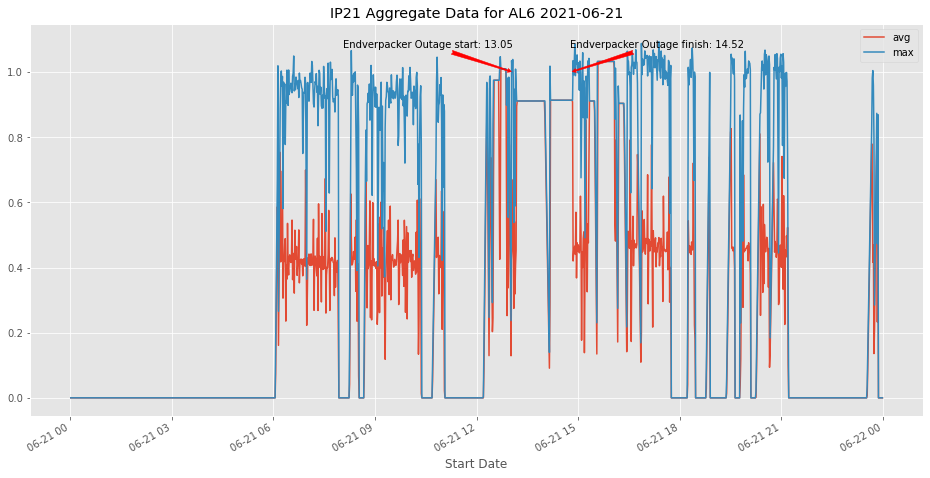

In [110]:
import matplotlib.pyplot as plt
df_IP21[['avg','max']][df_IP21.name == '36630901_S130HEIGHT_L9'].plot(figsize=(16,8), title='IP21 Aggregate Data for AL6 2021-06-21')
# plt.annotate(s='',Direction xy=('2021-06-21 13:05:00', 60), xytext=('2021-06-21 13:05:00', 0), arrowprops=dict(arrowstyle='<-<')
# plt.show())
plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )       

In [111]:
df_IP21[df_IP21.name.str.contains('36630901_S130HEIGHT_L9')]

,name,avg,min,max,std,sum
Start Date,,,,,,
2021-06-21 00:01:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-06-21 00:02:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-06-21 00:03:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-06-21 00:04:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-06-21 00:05:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-06-21 23:55:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-06-21 23:56:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-06-21 23:57:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0


read in the HISTORY table csv which is built using this statement

```
for (select NAME, FIELD_ID, TS, PERIOD, REQUEST, STEPPED, VALUE, STATUS, SECONDS
 from history
where name like '366%'
  and ts between '21-Jun-21 00:00:00.0' and '21-Jun-21 23:59:59.9') do 
	write name || ',' || field_id || ',' || ts || ',' || period || ',' || request || ',' || stepped || ',' || value || ',' || status || ',' || seconds;
end
```


In [112]:
# read in txt file
file = (dir_sanofi_share + 'OEE data/IP21_AL6_History_20210621.txt')
df_IP21_hist = pd.read_csv(file, parse_dates=True, index_col='Timestamp', header=None, names=('name', 'field_id', 'Timestamp', 'period', 'request', 'stepped', 'value','status','seconds'))
df_IP21_hist.shape

(249120, 8)

In [113]:
df_IP21_hist.head()

,name,field_id,period,request,stepped,value,status,seconds
Timestamp,,,,,,,,
2021-06-21 00:00:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226400
2021-06-21 00:01:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226460
2021-06-21 00:02:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226520
2021-06-21 00:03:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226580
2021-06-21 00:04:00,36630901_CNTRB_ST6,605618176,+000:01:00.0,1,0,0.0,0,1624226640


Text(2021-06-21 14.51:46:00, 1.1, 'Endverpacker Outage finish: 14.52')

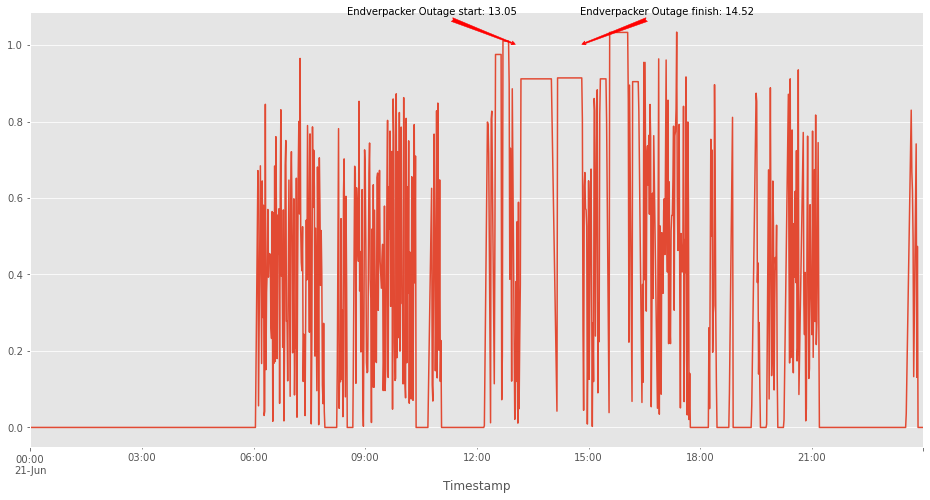

In [114]:
df_IP21_hist['value'][df_IP21_hist.name == '36630901_S130HEIGHT_L9'].plot(figsize=(16,8))

plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )       

Identify all Endverpacker outages from looking at the QlikSense detailed events output

In [115]:
df_Endverpacker = pd.read_excel(dir_sanofi_share + 'OEE data/AL6_OEE_Detailed_Events_Endverpacker.xlsx', parse_dates=True, index_col='Start Date')

In [116]:
df_Endverpacker.head()

,Shift Long Name,End Date,Duration (min.),Stoppage Reason 3,Last Level Reason,Machine,Comments,Creator
Start Date,,,,,,,,
2021-04-01 09:36:34,FRUE - 01/04/2021 06:00:00,2021-04-01 09:43:49,7.250000,Störungen und Fehlerbehebung (25),Verklebestation (251270507),AL6 Endverpacker,-,DE013273
2021-04-01 10:03:19,FRUE - 01/04/2021 06:00:00,2021-04-01 10:13:37,10.300000,Störungen und Fehlerbehebung (25),Stapeleinheit (251270502),AL6 Endverpacker,-,DE013273
2021-04-01 10:16:25,FRUE - 01/04/2021 06:00:00,2021-04-01 10:23:19,6.900000,Störungen und Fehlerbehebung (25),Stapeleinheit (251270502),AL6 Endverpacker,-,DE013273
2021-04-01 15:43:49,SPAE - 01/04/2021 14:00:00,2021-04-01 15:47:39,3.833333,Störungen und Fehlerbehebung (25),Verklebestation (251270507),AL6 Endverpacker,-,DE017461
2021-04-01 15:49:44,SPAE - 01/04/2021 14:00:00,2021-04-01 15:58:00,8.266667,Störungen und Fehlerbehebung (25),Verklebestation (251270507),AL6 Endverpacker,-,DE017461


In [117]:
outages = df_Endverpacker['Duration (min.)'].sum()
count = df_Endverpacker.count()

print ("Minutes lost to Endverpacker outages since 2021-04-01: {:,.2f} mins".format(outages))

Minutes lost to Endverpacker outages since 2021-04-01: 1,741.12 mins


In [118]:

df_Endverpacker.describe()

,Duration (min.)
count,211.000000
mean,8.251738
std,13.598047
min,0.016667
25%,0.808333
50%,5.400000
75%,9.900000
max,106.766667


In [119]:
stats = df_Endverpacker['Duration (min.)'].groupby(pd.Grouper(freq='D')).describe().reset_index()



read in aggregates for Endverpacker which was extracted using this:

```
for (select name, ts, avg, min, max, std, sum from aggregates
where name = '36630901_S130HEIGHT_L9'
 and ts between '01-Jan-21 0:00:00.0' and '28-Jul-21 23:59:59.9') do
write name || ',' || ts || ',' || avg || ',' || min || ',' || max || ',' || std || ',' || sum;
end
```

In [120]:
# read in txt file
file = (dir_sanofi_share + 'OEE data/IP21_AL6_Aggregates_Endverpacker.txt')
df_IP21_agg_Endverpacker = pd.read_csv(file, parse_dates=True, index_col='Start Date', header=None, names=('name', 'Start Date', 'avg', 'min', 'max', 'std', 'sum'))
df_IP21_agg_Endverpacker.shape

(300899, 6)

In [121]:
df_IP21_agg_Endverpacker.head()

,name,avg,min,max,std,sum
Start Date,,,,,,
2021-01-01 00:01:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-01-01 00:02:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-01-01 00:03:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-01-01 00:04:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0
2021-01-01 00:05:00,36630901_S130HEIGHT_L9,0.0,0.0,0.0,0.0,0.0


Do I need to get the dates of Endverpacker outages and then search for IP21 data, or find timestamps in IP21 that are near? 

In [122]:
Endverpacker_dates = df_Endverpacker.index.map(pd.Timestamp.date).unique()

In [123]:
df_Endverpacker_merge = pd.merge_asof(df_Endverpacker.sort_index(), df_IP21_agg_Endverpacker.sort_index(), left_index=True, right_index=True, allow_exact_matches=True, direction='forward')

Text(2021-06-21 13:05:00, 1.4, '2021-06-21')

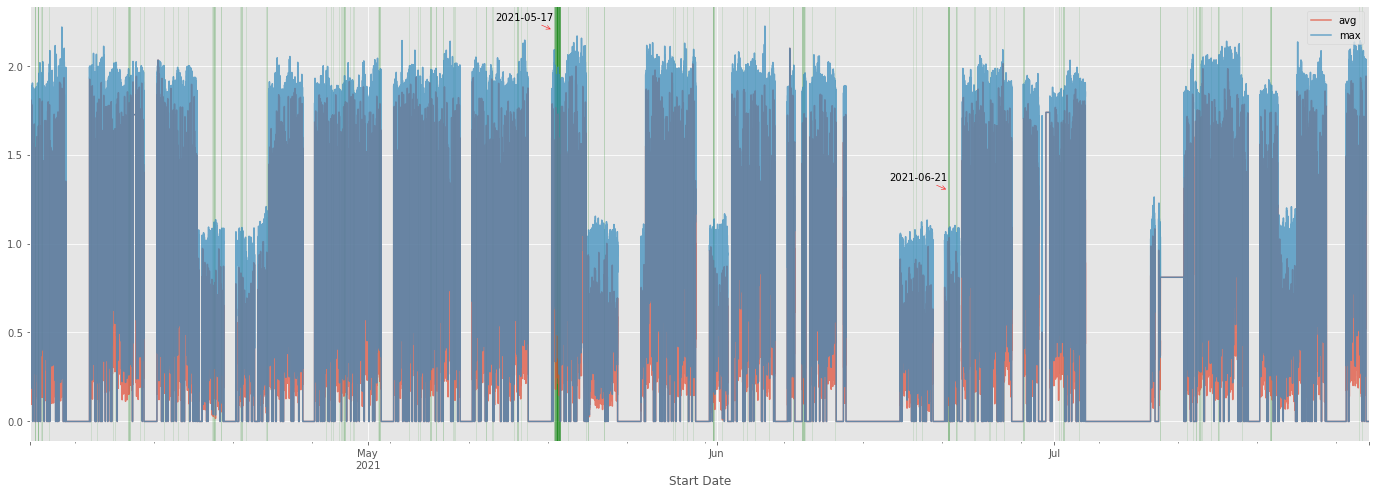

In [124]:
df_IP21_agg_Endverpacker[['avg','max']][df_IP21_agg_Endverpacker.index > start_date].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.2)
plt.annotate('2021-05-17', xy=('2021-05-17 10.00:00:00', 2.2),  xycoords='data',
            xytext=('2021-05-17 12.00:00:00', 2.3),
            arrowprops=dict(arrowstyle="->", color='red'),
            horizontalalignment='right', verticalalignment='top',
            ) 
plt.annotate('2021-06-21', xy=('2021-06-21 13:05:00', 1.3),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.4),
            arrowprops=dict(arrowstyle="->", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )


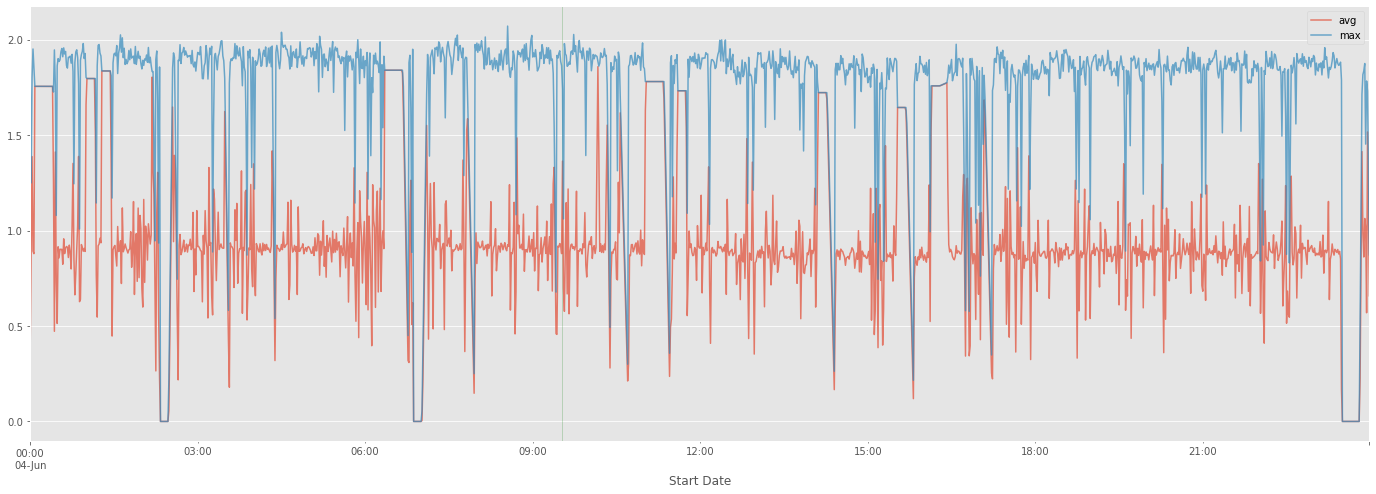

In [125]:
df_IP21_agg_Endverpacker[['avg','max']].loc['2021-06-04'].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.4)

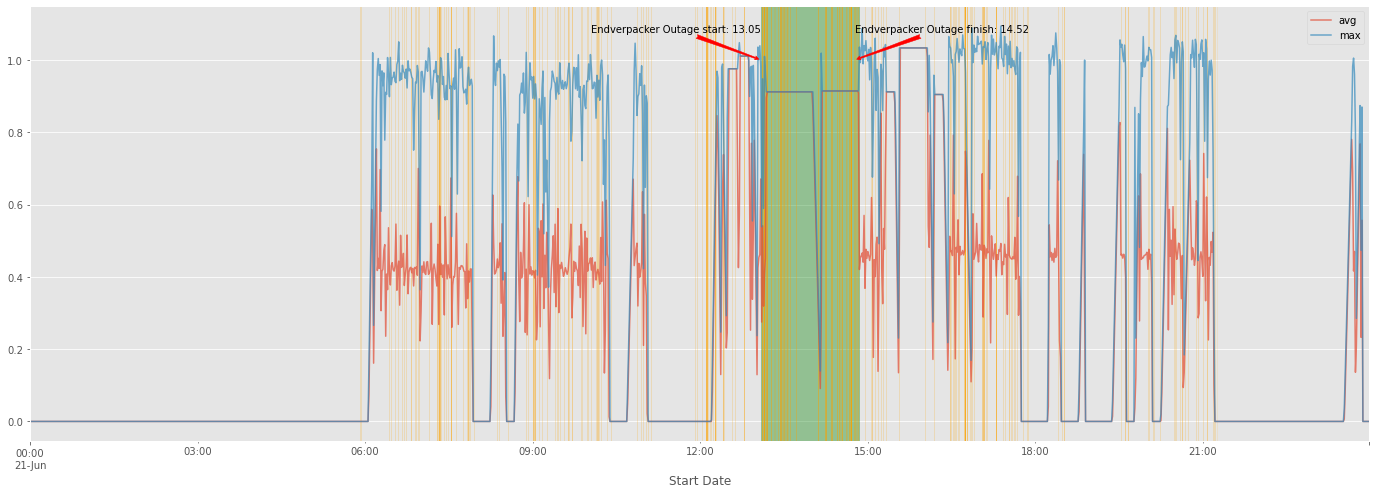

In [136]:
df_IP21_agg_Endverpacker[['avg','max']].loc['2021-06-21'].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.2)
plt.annotate('Endverpacker Outage start: 13.05', xy=('2021-06-21 13:05:00', 1),  xycoords='data',
            xytext=('2021-06-21 13:05:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.annotate('Endverpacker Outage finish: 14.52', xy=('2021-06-21 14.51:46:00', 1),  xycoords='data',
            xytext=('2021-06-21 14.51:46:00', 1.1),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            ) 
for i, row in df_alarms.iterrows():
    plt.axvspan(i, i, color='orange', alpha=0.2)

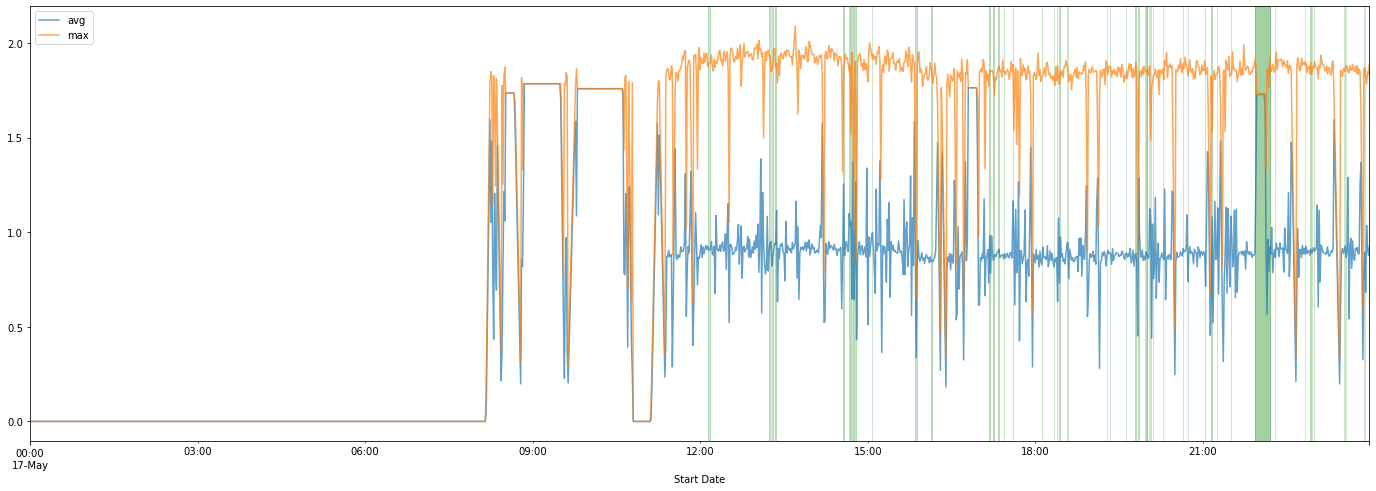

In [300]:
df_IP21_agg_Endverpacker[['avg','max']].loc['2021-05-17'].plot(figsize=(24,8), alpha=0.7)
for i, row in df_Endverpacker_merge.iterrows():
    plt.axvspan(i, row[1], color='green', alpha=0.2)

In [247]:
df_OEE[df_OEE.OEE == 100]

,Category,OEE,Month,Day
Date,,,,
2021-07-04,Malfunctions and troubleshooting,100.0,July,04


In [313]:
df_OEE['dayofweek'] = df_OEE.index.to_series().dt.dayofweek

<AxesSubplot:xlabel='dayofweek'>

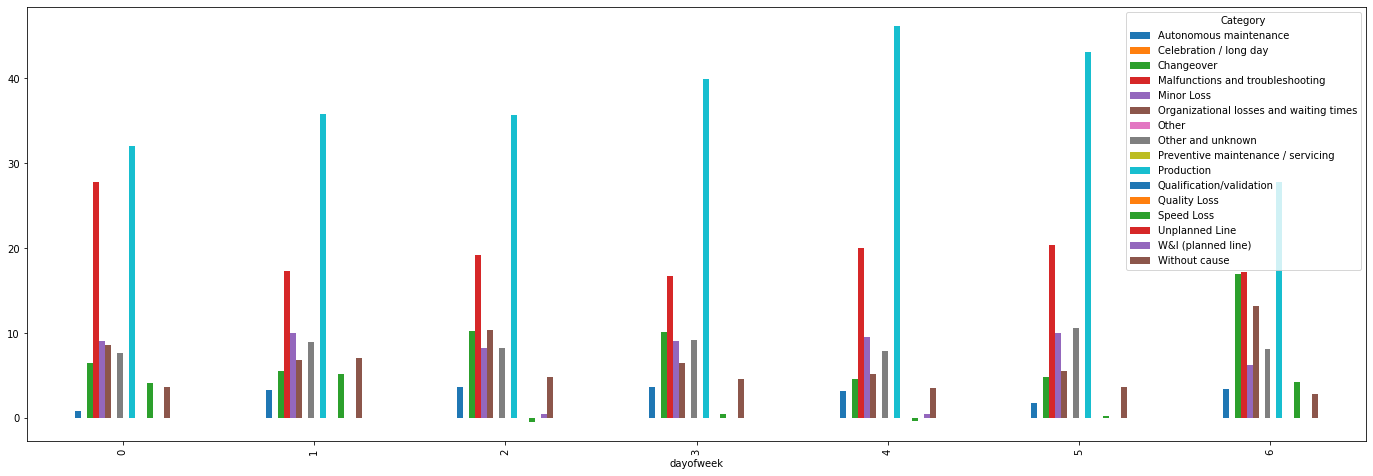

In [351]:
day = df_OEE.groupby(['Category','dayofweek']).mean().reset_index()
day.pivot(index='dayofweek', columns='Category', values='OEE').plot.bar(figsize=(24,8))

In [317]:
df_OEE

,Category,OEE,Month,Day,dayofweek
Date,,,,,
2021-04-01,Qualification/validation,0.000000,April,01,3
2021-04-01,Production,43.382099,April,01,3
2021-04-01,Minor Loss,12.870370,April,01,3
2021-04-01,Without cause,2.106481,April,01,3
2021-04-01,Other and unknown,10.745370,April,01,3
...,...,...,...,...,...
2021-07-19,Other,0.000000,July,19,0
2021-07-19,Unplanned Line,0.000000,July,19,0
2021-07-19,Minor Loss,6.505450,July,19,0


# Get the alarms data

In [36]:
file = (dir_alarms + 'AL6_Endverpacker/20210621_Alarms.xlsx')
df_alarms = pd.read_excel(file, parse_dates=True, index_col='TimeIn')

In [38]:
df_alarms.MessageText.unique()

array(['Maschine startbereit', 'Maschine startet',
       'Maschine wartet auf Produkte', 'Roboter: Palette voll',
       'FTS: Maschine wartet auf Palettenabholung', 'Maschine hält an',
       'Schutztür 1 geöffnet', 'FTS: Maschine wartet auf Leerpaletten',
       'Palettenmagazin: Vorwarnung Palettenende',
       'Palettenmagazin: Paletten sind zu Ende',
       'Palettenmagazin: Lichtgitter ist unterbrochen',
       'Palettenmagazin: Lichtgitter quittieren',
       'Ausschleusvorrichtung: Karton wird ausgeschleust',
       'IPC Karton: Karton wurde ausgeschleust',
       'Zylinderkontrolle: Palettenübersetzer Lückenschließer an Palettenabschub öffnen',
       'Palette leerfahren ist angewählt',
       'Palettenaustransport 2: Sicherheitslichtschranke unterbrochen',
       'Sicherheitskreis der Türen unterbrochen',
       'Palettenaustransport 2: Frequenzumrichter',
       'Palettenaustransport 2: Sicherheitslichtschranke rücksetzen',
       'Kein Batch aktiv - Maschinenstart verriege

In [42]:
df_alarms.replace({
'Maschine startbereit':'Machine ready to start',
'Maschine startet':'Machine starts',
'Maschine wartet auf Produkte':'Machine is waiting for products',
'Roboter: Palette voll':'Robot: pallet full',
'FTS: Maschine wartet auf Palettenabholung':'AGV: machine is waiting for pallet pick-up',
'Maschine hält an':'Machine stops',
'Schutztür 1 geöffnet':'Protective door 1 open',
'FTS: Maschine wartet auf Leerpaletten':'AGV: machine is waiting for empty pallets',
'Palettenmagazin: Vorwarnung Palettenende':'Pallet magazine: prewarning pallet end',
'Palettenmagazin: Paletten sind zu Ende':'Pallet magazine: pallets have run out',
'Palettenmagazin: Lichtgitter ist unterbrochen':'Pallet magazine: light curtain is interrupted',
'Palettenmagazin: Lichtgitter quittieren':'Pallet magazine: acknowledge light curtain',
'Ausschleusvorrichtung: Karton wird ausgeschleust':'Ejection device: carton is ejected',
'IPC Karton: Karton wurde ausgeschleust':'IPC carton: carton was ejected',
'Zylinderkontrolle: Palettenübersetzer Lückenschließer an Palettenabschub öffnen':'Cylinder control: pallet translator open gap closer on pallet push-off',
'Palette leerfahren ist angewählt':'Empty pallet is selected',
'Palettenaustransport 2: Sicherheitslichtschranke unterbrochen':'Pallet outfeed 2: safety light barrier interrupted',
'Sicherheitskreis der Türen unterbrochen':'Safety circuit of the doors interrupted',
'Palettenaustransport 2: Frequenzumrichter':'Pallet transport 2: frequency converter',
'Palettenaustransport 2: Sicherheitslichtschranke rücksetzen':'Pallet outfeed 2: reset safety light barrier',
'Kein Batch aktiv - Maschinenstart verriegelt!':'No batch active - machine start locked!',
'Kamerasystem 3: ausgeschaltet':'Camera system 3: switched off',
'Kamerasystem 4: ausgeschaltet':'Camera system 4: switched off',
'Track & Trace System: Nicht betriebsbereit':'Track & Trace System: Not ready for operation',
'Schutztür 2 geöffnet':'Protective door 2 open',
'Kamerasystem 3: Kein "Gut" Signal':'Camera system 3: No "good" signal',
'Ausschleusvorrichtung: Ausschleusung Serienfehler Etikett':'Reject device: rejection of serial error label',
'Palettenmagazin: Sicherheitslichtschranke Muting Zeitüberlauf':'Pallet magazine: Muting safety light barrier time overflow',
'Ausschleusvorrichtung: Karton wurde nicht ausgeschleust':'Ejection device: carton was not ejected',
'Roboter: Karton verloren in Abholposition':'Robot: carton lost in pick-up position',
'Roboter: verlorener Karton in Abholposition entfernt?':'Robot: lost carton removed from pick-up position?'
}, inplace=True)

In [199]:
df_alarms.loc['2021-06-21'].groupby('MessageText')['MessageText'].count().sort_values(ascending=False)

MessageText
Machine is waiting for products                                           315
Camera system 3: No "good" signal                                          44
Machine ready to start                                                     44
Machine starts                                                             42
Machine stops                                                              42
AGV: machine is waiting for pallet pick-up                                 32
Track & Trace System: Not ready for operation                              28
Robot: pallet full                                                         24
Reject device: rejection of serial error label                             12
Protective door 1 open                                                     10
Protective door 2 open                                                      6
Pallet magazine: prewarning pallet end                                      6
Safety circuit of the doors interrupted             

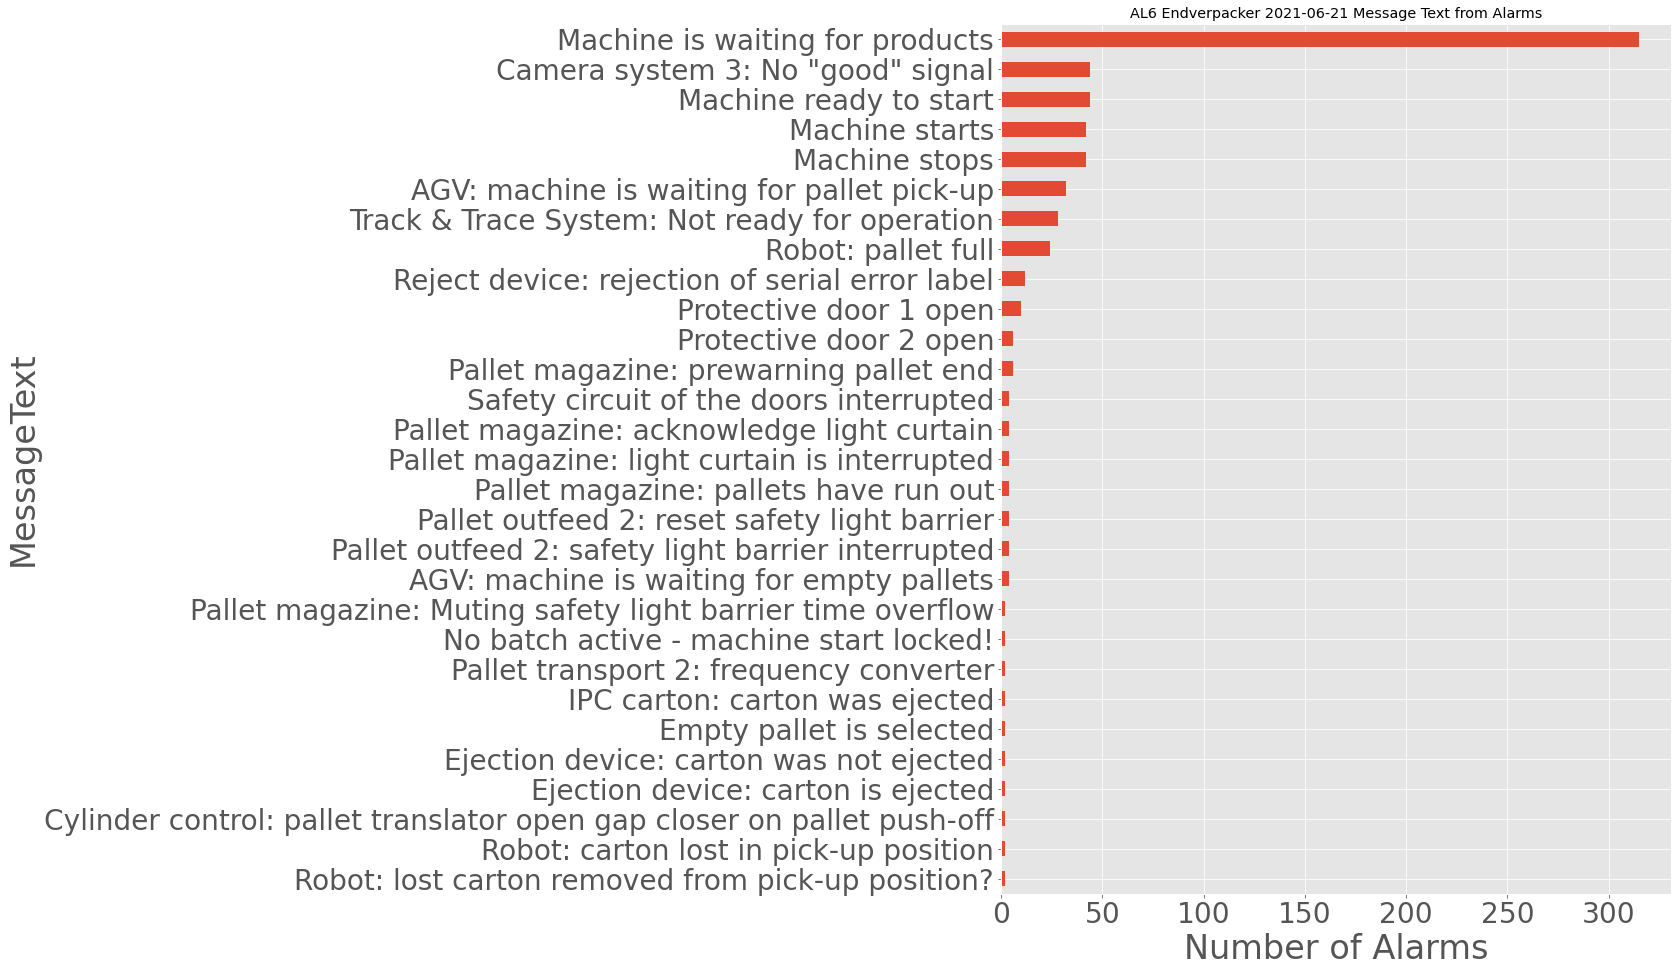

In [197]:
df_alarms.loc['2021-06-21'].groupby('MessageText')['MessageText'].count().sort_values(ascending=True).plot.barh(figsize=(12,16))
plt.style.use('ggplot')
plt.title('AL6 Endverpacker 2021-06-21 Message Text from Alarms')
plt.xlabel('Number of Alarms')
plt.rcParams.update({'font.size': 28})
plt.show()

In [182]:
df_alarms.to_excel(dir_sanofi_share + 'OEE data/AL6_Endverpacker_alarms.xlsx')

In [135]:
df_alarms.filter(regex='Time')

,TimeUserAck,TimePLCAck,TimeInUTC
TimeIn,,,
2021-06-20 05:38:01.758,00:00:00,2021-06-21 05:54:53.422000,2021-06-20 03:38:02
2021-06-21 05:54:53.422,00:00:00,00:00:00,2021-06-21 03:54:53
2021-06-21 05:54:53.422,00:00:00,2021-06-21 05:54:55.602000,2021-06-21 03:54:53
2021-06-21 05:55:15.615,00:00:00,00:00:00,2021-06-21 03:55:16
2021-06-21 05:55:15.615,00:00:00,2021-06-21 06:22:34.969000,2021-06-21 03:55:16
...,...,...,...
2021-06-21 21:12:45.295,00:00:00,00:00:00,2021-06-21 19:12:45
2021-06-21 21:12:45.295,00:00:00,2021-06-21 21:12:46.286000,2021-06-21 19:12:45
2021-06-21 21:13:26.213,00:00:00,00:00:00,2021-06-21 19:13:26


In [140]:
df_alarms.filter(regex='Time')



,TimeUserAck,TimePLCAck,TimeInUTC
TimeIn,,,
2021-06-20 05:38:01.758,00:00:00,2021-06-21 05:54:53.422000,2021-06-20 03:38:02
2021-06-21 05:54:53.422,00:00:00,00:00:00,2021-06-21 03:54:53
2021-06-21 05:54:53.422,00:00:00,2021-06-21 05:54:55.602000,2021-06-21 03:54:53
2021-06-21 05:55:15.615,00:00:00,00:00:00,2021-06-21 03:55:16
2021-06-21 05:55:15.615,00:00:00,2021-06-21 06:22:34.969000,2021-06-21 03:55:16
...,...,...,...
2021-06-21 21:12:45.295,00:00:00,00:00:00,2021-06-21 19:12:45
2021-06-21 21:12:45.295,00:00:00,2021-06-21 21:12:46.286000,2021-06-21 19:12:45
2021-06-21 21:13:26.213,00:00:00,00:00:00,2021-06-21 19:13:26


In [184]:
df_alarms[df_alarms['MessageText'].str.contains('Camera')].loc['2021-06-21']

,ID,State,StateID,StateText,TimeUserAck,TimePLCAck,MessageID,MessageText,Occur,GroupID,...,Parameter1,Parameter2,Group,Class,HistoricalID,HasNotes,SortBuffer,TimeInUTC,User,Machine
TimeIn,,,,,,,,,,,,,,,,,,,,,
2021-06-21 13:06:57.746,917,4,$2522,MGK,00:00:00,00:00:00,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,256,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:06:58,NaN,FRAM28556
2021-06-21 13:06:57.746,917,0,$2524,MGG,00:00:00,2021-06-21 13:06:59.956000,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,257,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:06:58,NaN,FRAM28556
2021-06-21 13:08:24.092,917,4,$2522,MGK,00:00:00,00:00:00,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,262,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:08:24,NaN,FRAM28556
2021-06-21 13:08:24.092,917,0,$2524,MGG,00:00:00,2021-06-21 13:08:26.251000,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,263,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:08:24,NaN,FRAM28556
2021-06-21 13:09:28.422,917,4,$2522,MGK,00:00:00,00:00:00,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,271,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:09:28,NaN,FRAM28556
2021-06-21 13:09:28.422,917,0,$2524,MGG,00:00:00,2021-06-21 13:09:29.412000,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,273,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:09:28,NaN,FRAM28556
2021-06-21 13:11:44.716,917,4,$2522,MGK,00:00:00,00:00:00,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,284,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:11:45,NaN,FRAM28556
2021-06-21 13:11:44.716,917,0,$2524,MGG,00:00:00,2021-06-21 13:11:46.804000,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,285,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:11:45,NaN,FRAM28556
2021-06-21 13:12:37.743,917,4,$2522,MGK,00:00:00,00:00:00,$9686,"Camera system 3: No ""good"" signal",1,$9684,...,$9522,18174,69,5,290,False,Alarmhistory_21-6-21--5-5,2021-06-21 11:12:38,NaN,FRAM28556
